# Credit Scoring


- Import necessary packages

In [1]:
# Load data manipulation package
import numpy as np
import pandas as pd
import itertools

# Load data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# Scorecard Development Process

## Scorecard Development Process

**1. Explore data.**
- Simple statistics such as distributions of values, mean/median, etc.
- Checking data integrity.

**2. Handle missing values and outliers.**
- Most financial industry data contains missing values, or values that do not make sense for a particular characteristic

**3. Check correlation.**

**4. Initial characteristic analysis.**
- To assess the strength of each characteristic individually as a predictor of performance.

**5. Statistical Measures.**
- Weight of Evidence (WoE) — measures the strength of each attribute.
- Information Value (IV) — measures the total strength of the characteristic.

**6. Check logical trend.**
- Attribute strengths must also be in a logical order, and make operational sense.

**7. Check business/operational considerations.**
- The consideration is business or operational relevance. e.g. postal codes.

**8. Design scorecards.**
- Preliminary scorecard
- Reject inference — To make educated guesses about how rejected applicants would have performed if accepted.
- Final scorecard production

**9. Choose a scorecard — using a combination of statistical and business measures.**
- For example: misclassification, scorecard strength (KS, Chi-square, AIC, AUC), etc.



__________________________

## Example of Scorecard Creation

This is an end-to-end example to show how a scorecard is created.
This is a highly simplified one, designed to show how the final scores are calculated.


# 1. Data Loading

The sample we will use in this example is a fictive dataset from here.
The sample consist of some demographic, bureau, and financial information.
Note that we are not defining the default or bad status from our dataset here. Instead, we already have the binary response variable:

    - loan_status
        * loan_status = 0 for non default loan.
        * loan_status = 1 for default loan.

The potential characteristics for predicting the response variable are:

1. person age
2. person_income (the annual income of the debtor)
3. person_home_ownership
    - RENT
    - MORTGAGE
    - OWN
    - OTHER
4. person_emp_length (the employment length of debtor in years)
5. loan_intent (the purpose of loan)
    - EDUCATION
    - MEDICAL
    - VENTURE
    - PERSONAL
    - DEBTCONSOLIDATION
6. loan_grade
7. loan_amnt (loan amount)
8. loan_int_rate (interest rate)
9. loan_percent_income (percent loan of income)
10. cb_person_default_on_file (historical default)
    - 0 : the debtor does not have any history of defaults.        
    - 1 : the debtor has a history of defaults on their credit file.
    cb_preson_cred_hist_length (credit history length)



In [2]:
# Import dataset from csv file
data = pd.read_csv('credit_risk_dataset.csv')

# data check
data.head().T

,0,1,2,3,4
person_age,22,21,25,23,24
person_income,59000,9600,9600,65500,54400
person_home_ownership,RENT,OWN,MORTGAGE,RENT,RENT
person_emp_length,123.0,5.0,1.0,4.0,8.0
loan_intent,PERSONAL,EDUCATION,MEDICAL,MEDICAL,MEDICAL
loan_grade,D,B,C,C,C
loan_amnt,35000,1000,5500,35000,35000
loan_int_rate,16.02,11.14,12.87,15.23,14.27
loan_status,1,0,1,1,1
loan_percent_income,0.59,0.1,0.57,0.53,0.55


In [3]:
# Check the data shape
data.shape

(32581, 12)

Our sample contains 12 variables from 32,581 credit records.
- 1 response variable, loan_status,
- 11 potential characteristics/predictors.

Please note that in this example, we will use only 3 predictors, for the sake of simplicity.
- Predictor 1: person_age
- Predictor 4: person_emp_length
- Predictor 11: cb_person_default_on_file



In [4]:
data0 = data.copy()

# Use only 3 predictors and 1 response variable
data = data[['person_age',
             'person_emp_length',
             'cb_person_default_on_file',
             'loan_status']]
data

,person_age,person_emp_length,cb_person_default_on_file,loan_status
0,22,123.0,Y,1
1,21,5.0,N,0
2,25,1.0,N,1
3,23,4.0,N,1
4,24,8.0,Y,1
...,...,...,...,...
32576,57,1.0,N,0
32577,54,4.0,N,0
32578,65,3.0,N,1
32579,56,5.0,N,0


Before modeling, make sure you split the data first for model validation.
In the classification case, check the proportion of response variable first to decide the splitting strategy.

In [5]:
# Define response variable
response_variable = 'loan_status'

# Check the proportion of response variable
data[response_variable].value_counts(normalize = True)

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

The proportion of the response variable, loan status, is not quite balanced (in a ratio of 78:22).
To get the same ratio in training and testing set, define a stratified splitting based on the response variable, loan_status.


# 2. Sample Splitting

First, define the predictors (X) and the response (y).

In [6]:
# Split response and predictors
y = data[response_variable]
X = data.drop(columns = [response_variable],
              axis = 1)

# Validate the splitting
print('y shape :', y.shape)
print('X shape :', X.shape)

y shape : (32581,)
X shape : (32581, 3)


Next, split the training and testing set from each predictors (X) and response (y).

- Set stratify = y for splitting the sample with stratify, based on the proportion of response y.
- Set test_size = 0.3 for holding 30% of the sample as a testing set.
- Set random_state = 42 for reproducibility.



In [7]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 42)

# Validate splitting
print('X train shape :', X_train.shape)
print('y train shape :', y_train.shape)
print('X test shape  :', X_test.shape)
print('y test shape  :', y_test.shape)

X train shape : (22806, 3)
y train shape : (22806,)
X test shape  : (9775, 3)
y test shape  : (9775,)


Check the proportion of response y in each training and testing set.

In [8]:
y_train.value_counts(normalize = True)

loan_status
0    0.781856
1    0.218144
Name: proportion, dtype: float64

In [9]:
y_test.value_counts(normalize = True)

loan_status
0    0.78179
1    0.21821
Name: proportion, dtype: float64

## 3. Exploratory Data Analysis

- To make a model that predicts well on unseen data, we must prevent leakage of test set information.
- Thus, we only explore on training set.

In [10]:
# Concatenate X_train and y_train as data_train
data_train = pd.concat((X_train, y_train),
                       axis = 1)

# Validate data_train
print('Train data shape:', data_train.shape)
data_train.head()

Train data shape: (22806, 4)


,person_age,person_emp_length,cb_person_default_on_file,loan_status
11491,26,1.0,N,0
3890,23,3.0,N,0
17344,24,1.0,N,1
13023,24,1.0,N,0
29565,42,4.0,N,1


What do we do in EDA?
- Check data integrity.
- Check for any insight in the data: distribution, proportion, outliers, missing values, etc.
- Make a plan for data pre-processing.



### Check for Missing Values

In [11]:
# Check for missing values
data_train.isna().sum()

person_age                     0
person_emp_length            639
cb_person_default_on_file      0
loan_status                    0
dtype: int64

In [12]:
# Check for data type
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22806 entries, 11491 to 10456
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 22806 non-null  int64  
 1   person_emp_length          22167 non-null  float64
 2   cb_person_default_on_file  22806 non-null  object 
 3   loan_status                22806 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 890.9+ KB


**Summary**
- There are missing values in person_emp_length, a numerical/float variable.
- We need to find how to handle the missing values by exploring this variable.



### Predictor 1: person_age¶

In [13]:
# Descriptive statistics of 'person_age'
data_train['person_age'].describe()

count    22806.000000
mean        27.722880
std          6.336638
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64

<Axes: xlabel='person_age', ylabel='Count'>

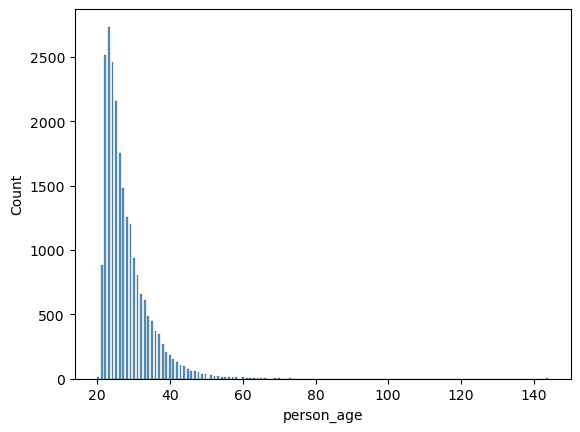

In [14]:
# Distribution plot of person_age

sns.histplot(data = data_train,
             x = 'person_age')

In [15]:
# Descriptive of person_age by response loan_status
data['person_age'].groupby(data_train[response_variable]).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0.0,17831.0,27.784981,6.337859,20.0,23.0,26.0,30.0,144.0
1.0,4975.0,27.500302,6.327888,20.0,23.0,26.0,30.0,70.0


<Axes: xlabel='loan_status', ylabel='person_age'>

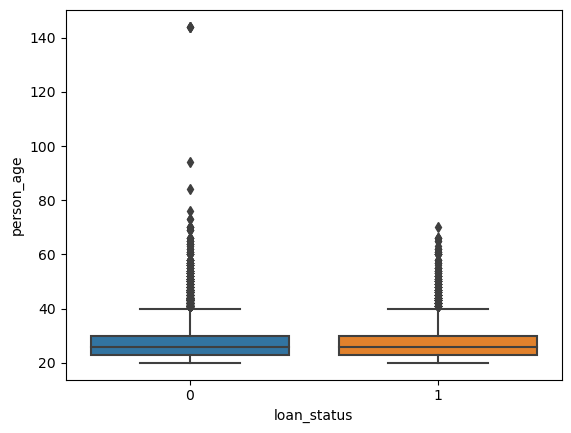

In [16]:
# Boxplot of person_age by response loan_status
sns.boxplot(data = data_train,
            x = response_variable,
            y = 'person_age')

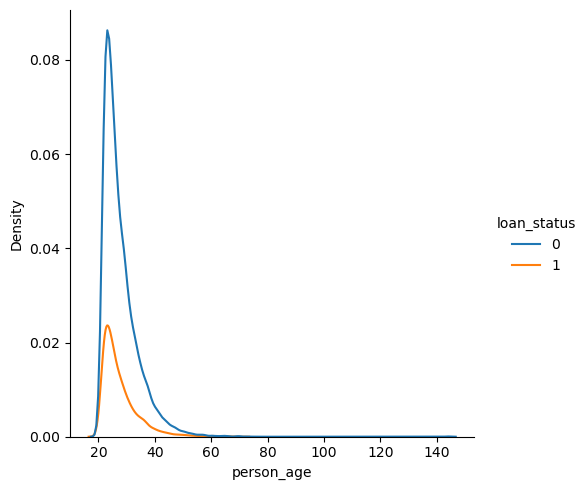

In [17]:
# Distribution plot of person_age by response loan_status
sns.displot(data = data_train,
            x = 'person_age',
            hue = response_variable,
            kind = 'kde')

- We may assume there are outliers for the age over 80 years old.
- But we can check the maximum threshold for outliers from the IQR method below.

In [18]:
# Calculate Q1 and Q3
Q1_person_age = np.percentile(data_train['person_age'], 25)
Q3_person_age = np.percentile(data_train['person_age'], 75)

# Calculate IQR
IQR_person_age = Q3_person_age - Q1_person_age

# Calculate the thresholds
min_person_age = Q1_person_age - 1.5*IQR_person_age
max_person_age = Q3_person_age + 1.5*IQR_person_age

min_person_age, max_person_age

(12.5, 40.5)

From the IQR, debtors younger than 12.5 years and older than 40.5 years are outliers.

Assumptions:
- The age regulation for the applicant is a minimum of 21 years old.
- Applicants older than 40.5 to 55 may still be in productive age.

Therefore, we can define outliers from person_age variable with the following condition.


In [19]:
# Define minimum and maximum age with adjustment
adj_min_person_age = 21
adj_max_person_age = 55

# Define outliers
outliers_person_age_min = data_train['person_age'] < 21
outliers_person_age_max = data_train['person_age'] > 55

outliers_person_age = np.where(outliers_person_age_min | outliers_person_age_max)[0]

# Check the number of outliers in data_train
len(outliers_person_age)

114

In [20]:
# Check missing values
data_train['person_age'].isna().sum()

0

**Summary**
- There seems to be no age difference between the default and non-default groups.
- Potential outliers over 80 years old come from the non-default group.
- The youngest debtor is 20 years old.
- Three-quarters of the debtors are up to 30 years old. The rest are over 30 years old.

**Business Insight:**
- Check the regulations to see whether we will accept applicants aged 20 years.
- If not, are debtors aged 20 still included in the sample?
- Check the maximum age limit for the applicant and adjust it to the tenor.

**Pre-processing Plan:**
- There are no missing values.
- The outliers will be grouped.

### Predictor 4: person_emp_length

In [21]:
# Descriptive statistics of 'person_emp_length'
data_train['person_emp_length'].describe()

count    22167.000000
mean         4.796905
std          4.120061
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

<Axes: xlabel='person_emp_length', ylabel='Count'>

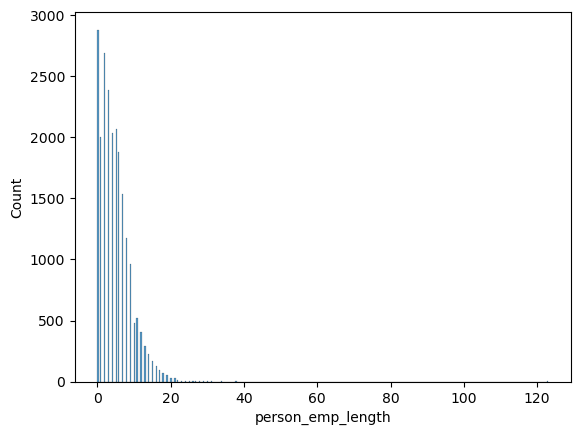

In [22]:
# Distribution plot of person_emp_length
sns.histplot(data = data_train,
             x = 'person_emp_length')

In [23]:
# Descriptive of person_emp_length by response loan_status
data_train['person_emp_length'].groupby(data_train[response_variable]).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,17388.0,4.978951,4.161727,0.0,2.0,4.0,7.0,123.0
1,4779.0,4.134547,3.894015,0.0,1.0,3.0,6.0,34.0


<Axes: xlabel='loan_status', ylabel='person_emp_length'>

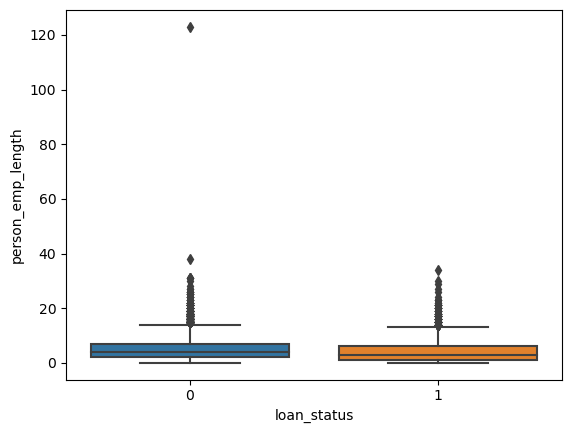

In [24]:
# Boxplot of person_emp_length by response loan_status
sns.boxplot(data = data_train,
            x = response_variable,
            y = 'person_emp_length')

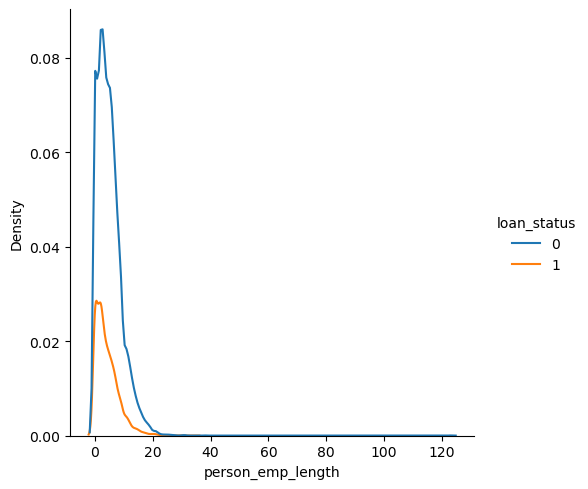

In [25]:
# Distribution plot of person_emp_length by response loan_status
sns.displot(data = data_train,
            x = 'person_emp_length',
            hue = response_variable,
            kind = 'kde')

In [26]:
# Check data integrity
underage_workers = (data_train['person_age'] - data_train['person_emp_length']) < 18

data_train[underage_workers]

,person_age,person_emp_length,cb_person_default_on_file,loan_status
25029,27,11.0,N,0
179,24,8.0,N,0
11278,25,9.0,N,0
13547,22,6.0,N,0
17324,23,7.0,N,1
...,...,...,...,...
13675,26,10.0,N,0
14989,24,8.0,N,0
10023,23,7.0,N,0
1663,22,7.0,N,0


In [27]:
# Check the proportion of underage workers
len(data_train[underage_workers])/len(data_train)

0.24006840305182847

In [28]:
# Check data integrity
invalid_workers =  data_train['person_emp_length'] > data_train['person_age']

data_train[invalid_workers]

,person_age,person_emp_length,cb_person_default_on_file,loan_status
210,21,123.0,N,0


- There is one invalid data where the employment's length exceeds the debtor's age.
- About 24% of debtors from the training set are debtors who started working before the age of 18 years.
        Do they come from the same distribution?



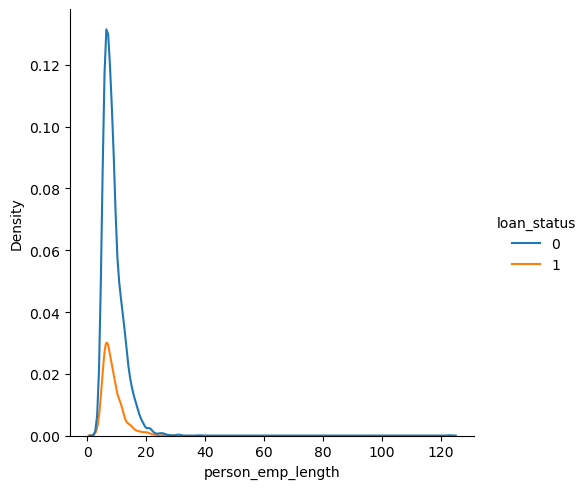

In [29]:
# Distribution plot of person_emp_length of underage_workers by response loan_status
sns.displot(data = data_train[underage_workers],
            x = 'person_emp_length',
            hue = response_variable,
            kind = 'kde')

In [30]:
# Check missing values
data_train['person_emp_length'].isna().sum()

639

**Summary**
- Three-quarters of debtors have worked for 0-7 years, half of the debtors have worked for more than four years.
- About 24% of debtors from the training set are debtors who started working before the age of 18 years.
- There is one invalid data where the employment's length exceeds the debtor's age.

**Pre-processing Plan:**
- Check data integrity: about 24% of debtors start working before 18. Is it valid and acceptable?
- We have 639 missing values.
- Plan A:
<br>        - 'Missing' is grouped separately, and
<br>        - 'Underage workers' is grouped separately if it's not acceptable.
- Plan B:
<br>        - Exclude the underage workers.
<br>        - Impute the missing values with the median.



### Predictor 11: cb_person_default_on_file


In [31]:
# Describe proportion of 'cb_person_default_on_file'
data_train['cb_person_default_on_file'].value_counts(normalize = True)

cb_person_default_on_file
N    0.822503
Y    0.177497
Name: proportion, dtype: float64

From here, we know that our sample is dominated by customers who never be in default, in a ratio of 82:18.


<Axes: xlabel='cb_person_default_on_file', ylabel='count'>

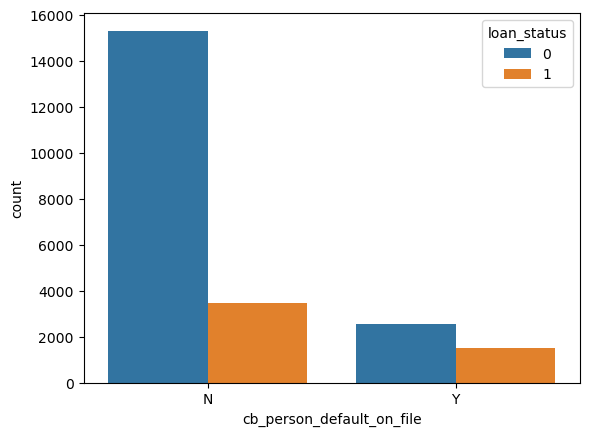

In [32]:
# Describe proportion of default by 'cb_person_default_on_file'
sns.countplot(data = data_train,
              x = 'cb_person_default_on_file',
              hue = response_variable)

Even though the count of defaults from debtors who never default is higher, the higher odds of default seem from those who have been in default before.

Let's check from the contingency table.


In [33]:
# Frequency of default by 'cb_person_default_on_file'
default_by_history = pd.crosstab(data_train['cb_person_default_on_file'],
                                 data_train[response_variable],
                                 margins = False)
default_by_history

loan_status,0,1
cb_person_default_on_file,,
N,15302,3456
Y,2529,1519


In [34]:
# Odds of default from those who never default
odds_never_default = default_by_history[1][0]/default_by_history[0][0]

# Odds of default from those who have been in default
odds_ever_default = default_by_history[1][1]/default_by_history[0][1]

print("Odds of default from debtors who:")
print(f"never default = {odds_never_default:.2f}")
print(f"ever default = {odds_ever_default:.2f}")

Odds of default from debtors who:
never default = 0.23
ever default = 0.60


Let's check from the independence test whether the debtors who have been in default are independent of the probability of default.

In [35]:
# Import the libraries
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Test whether churn is independent of TV subscriber
stats.chi2_contingency(default_by_history)

# Result of independence test
result = stats.chi2_contingency(default_by_history)

# Extract the test result
stat = result[0]
pval = result[1]

print(f"Chi-stat   : {stat:.4f}")
print(f"P-value    : {pval:.4f}")

Chi-stat   : 711.0770
P-value    : 0.0000


Let's make a function for running the independence test to see the conclusion practically.


In [36]:
# Create a function of independence test
def independence_test(data, predictor_label, alpha=0.05):
    """
    Funtion to perform the independence test.

    Parameters
    ----------
    data : array like
      The name of dataset.

    predictor_label : object
      The label of predictor variable.

    alpha : float in range[0,1], default = 0.05
      Probability of Type I Error (reject H0 when H0 is true).

    """
    # Build the contingency table
    crosstab = pd.crosstab(data[predictor_label],
                           data[response_variable],
                           margins = False)

    # Test whether churn is independent of the predictor
    stats.chi2_contingency(crosstab)

    # Result of independence test
    result = stats.chi2_contingency(crosstab)

    # Extract the test result
    stat = result[0]
    pval = result[1]

    # Print the conclusion
    if pval < alpha:
        print(f"Default and {predictor_label} is not independent with P-val={pval}.")
    else:
        print(f"Default and {predictor_label} is independent with P-val={pval}.")

In [37]:
# Perform the independence test
independence_test(data = data_train,
                  predictor_label = 'cb_person_default_on_file',
                  alpha = 0.05)

Default and cb_person_default_on_file is not independent with P-val=1.166741294176887e-156.


In [38]:
# Checking missing value
data_train['cb_person_default_on_file'].isna().sum()

0

**Summary**
- About 18% of debtors have a history of defaulting before.
- Debtors who have defaulted before tend to default again afterward.

**Pre-processing Plan:**
- There is no missing values.

## 4. Check Correlation

- We already checked the dependency between the response variable loan_status and the categorical predictor cb_person_default_on_file.
- Next we will check the Pearson correlation between numerical predictors to see whether we have multicollinearity in training set.



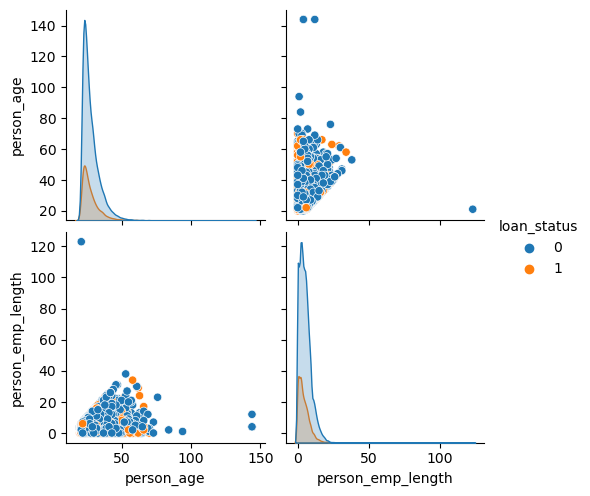

In [39]:
# Check the scatter plot
sns.pairplot(data_train,
             hue = response_variable)

In [40]:
# Calculate Pearson correlation coefficient from numerical predictors
data_train_corr = data_train.corr(method = 'pearson',
                                  numeric_only = True)

data_train_corr

,person_age,person_emp_length,loan_status
person_age,1.000000,0.171397,-0.018554
person_emp_length,0.171397,1.000000,-0.084284
loan_status,-0.018554,-0.084284,1.000000


<Axes: >

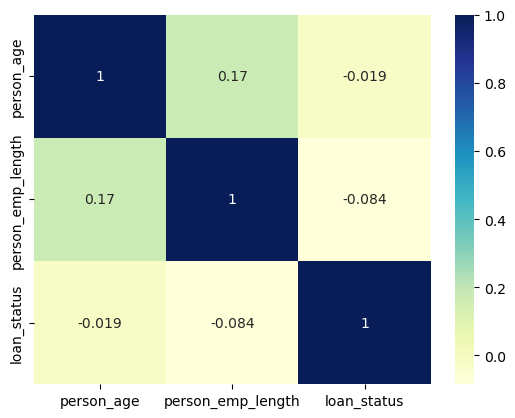

In [41]:
# Plot the heatmap correlation
sns.heatmap(data = data_train_corr,
            cmap = "YlGnBu",
            annot = True)

There is no multicollinearity in numerical predictors.

## 5. Initial Characteristic Analysis

We know from EDA that we have missing values and invalid data in a numerical predictor, person_emp_length.

There are two scenarios for the missing values.

- Plan A:
<br> - 'Missing' is grouped separately, and
<br> - 'Underage workers' is grouped separately if it's not acceptable.
- Plan B:
<br> - Exclude the underage workers.
<br> - Impute the missing values with the median.

Here, we will perform plan A to retain the sample's information as it is.

### 1. Binning

Create a function for binning the numerical predictors.
- person_age
- person_emp_length



In [42]:
# Create a function for binning the numerical predictor
def create_binning(data, predictor_label, num_of_bins):
    """
    Function for binning numerical predictor.

    Parameters
    ----------
    data : array like
      The name of dataset.

    predictor_label : object
      The label of predictor variable.

    num_of_bins : integer
      The number of bins.


    Return
    ------
    data : array like
      The name of transformed dataset.

    """
    data = data.copy()

    # Create a new column containing the binned predictor
    data[predictor_label + "_bin"] = pd.qcut(data[predictor_label],
                                             q = num_of_bins)

    return data

**Predictor 1: person_age**

In [43]:
# Bin person_age
data_train_binned = create_binning(data = data_train,
                                   predictor_label = 'person_age',
                                   num_of_bins = 4)

data_train_binned

,person_age,person_emp_length,cb_person_default_on_file,loan_status,person_age_bin
11491,26,1.0,N,0,"(23.0, 26.0]"
3890,23,3.0,N,0,"(19.999, 23.0]"
17344,24,1.0,N,1,"(23.0, 26.0]"
13023,24,1.0,N,0,"(23.0, 26.0]"
29565,42,4.0,N,1,"(30.0, 144.0]"
...,...,...,...,...,...
22095,32,3.0,N,0,"(30.0, 144.0]"
18736,30,0.0,N,0,"(26.0, 30.0]"
1663,22,7.0,N,0,"(19.999, 23.0]"
18257,29,4.0,Y,0,"(26.0, 30.0]"


In [44]:
# Check the proportion of each bin
data_train_binned['person_age_bin'].value_counts(normalize = True)

person_age_bin
(23.0, 26.0]      0.279225
(19.999, 23.0]    0.269227
(30.0, 144.0]     0.237481
(26.0, 30.0]      0.214066
Name: proportion, dtype: float64

In [45]:
# Frequency of default by person_age_bin
crosstab_age = pd.crosstab(data_train_binned['person_age_bin'],
                           data_train_binned[response_variable],
                           margins = True)
crosstab_age

loan_status,0,1,All
person_age_bin,,,
"(19.999, 23.0]",4671,1469,6140
"(23.0, 26.0]",5007,1361,6368
"(26.0, 30.0]",3856,1026,4882
"(30.0, 144.0]",4297,1119,5416
All,17831,4975,22806


**Predictor 4: person_emp_length**

In [46]:
# Bin person_emp_length
data_train_binned = create_binning(data = data_train_binned,
                                   predictor_label = 'person_emp_length',
                                   num_of_bins = 4)

data_train_binned

,person_age,person_emp_length,cb_person_default_on_file,loan_status,person_age_bin,person_emp_length_bin
11491,26,1.0,N,0,"(23.0, 26.0]","(-0.001, 2.0]"
3890,23,3.0,N,0,"(19.999, 23.0]","(2.0, 4.0]"
17344,24,1.0,N,1,"(23.0, 26.0]","(-0.001, 2.0]"
13023,24,1.0,N,0,"(23.0, 26.0]","(-0.001, 2.0]"
29565,42,4.0,N,1,"(30.0, 144.0]","(2.0, 4.0]"
...,...,...,...,...,...,...
22095,32,3.0,N,0,"(30.0, 144.0]","(2.0, 4.0]"
18736,30,0.0,N,0,"(26.0, 30.0]","(-0.001, 2.0]"
1663,22,7.0,N,0,"(19.999, 23.0]","(4.0, 7.0]"
18257,29,4.0,Y,0,"(26.0, 30.0]","(2.0, 4.0]"


In [47]:
# Check the proportion of each bin
data_train_binned['person_emp_length_bin'].value_counts(normalize = True)

person_emp_length_bin
(-0.001, 2.0]    0.342130
(4.0, 7.0]       0.247350
(7.0, 123.0]     0.210809
(2.0, 4.0]       0.199711
Name: proportion, dtype: float64

Remember, we have missing values.


In [48]:
# Check for missing values
data_train_binned['person_emp_length'].isna().sum()

639

Missing values will be grouped separately as 'Missing' category.


In [49]:
# Add category 'Missing' to replace the missing values
data_train_binned['person_emp_length_bin'] = data_train_binned['person_emp_length_bin'].cat.add_categories('Missing')

# Replace missing values with category 'Missing'
data_train_binned['person_emp_length_bin'].fillna(value = 'Missing',
                                                  inplace = True)

In [50]:
# Sanity check
data_train_binned['person_emp_length_bin'].isna().sum()

0

In [51]:
# Check the proportion of each bin
data_train_binned['person_emp_length_bin'].value_counts(normalize = True)

person_emp_length_bin
(-0.001, 2.0]    0.332544
(4.0, 7.0]       0.240419
(7.0, 123.0]     0.204902
(2.0, 4.0]       0.194116
Missing          0.028019
Name: proportion, dtype: float64

In [52]:
# Frequency of default by person_emp_length
crosstab_emp_length = pd.crosstab(data_train_binned['person_emp_length_bin'],
                                  data_train_binned[response_variable],
                                  margins = True)
crosstab_emp_length

loan_status,0,1,All
person_emp_length_bin,,,
"(-0.001, 2.0]",5533,2051,7584
"(2.0, 4.0]",3510,917,4427
"(4.0, 7.0]",4460,1023,5483
"(7.0, 123.0]",3885,788,4673
Missing,443,196,639
All,17831,4975,22806


### **2. WoE and IV**

To assess the strength of each characteristic individually as a predictor of the credit performance.

- Weight of Evidence (WoE) — measures the strength of each attribute.

$$
\begin{align*}
W_i &= \ln ( \% \text{Good} / \% \text{Bad} ) \\
W_i &= \ln \left ( \left ( \frac{N_i}{\sum N} \right ) / \left ( \frac{P_i}{\sum P} \right )\right ) \\
\end{align*}
$$

- Information Value (IV) — measures the total strength of the characteristic.

$$
\begin{align*}
IV &= \sum_{i=1}^{n} ( \% \text{Good} - \% \text{Bad} ) \times W_i \\
IV &= \sum_{i=1}^{n}\left [ \left ( \frac{N_i}{\sum N} - \frac{P_i}{\sum P} \right ) \times W_i \right ] \\
\end{align*}
$$

**Predictor 1: person_age**

In [53]:
# Display the crosstab
crosstab_age

loan_status,0,1,All
person_age_bin,,,
"(19.999, 23.0]",4671,1469,6140
"(23.0, 26.0]",5007,1361,6368
"(26.0, 30.0]",3856,1026,4882
"(30.0, 144.0]",4297,1119,5416
All,17831,4975,22806


In [54]:
crosstab_age[0]

person_age_bin
(19.999, 23.0]     4671
(23.0, 26.0]       5007
(26.0, 30.0]       3856
(30.0, 144.0]      4297
All               17831
Name: 0, dtype: int64

In [55]:
crosstab_age[0]['All']

17831

In [56]:
# Calculate % Good
crosstab_age['p_good'] = crosstab_age[0]/crosstab_age[0]['All']

# Calculate % Bad
crosstab_age['p_bad'] = crosstab_age[1]/crosstab_age[1]['All']

# Calculate the WOE
crosstab_age['WOE'] = np.log(crosstab_age['p_good']/crosstab_age['p_bad'])

# Calculate the contribution value for IV
crosstab_age['contribution'] = (crosstab_age['p_good']-crosstab_age['p_bad'])*crosstab_age['WOE']

In [57]:
# Display the result
crosstab_age

loan_status,0,1,All,p_good,p_bad,WOE,contribution
person_age_bin,,,,,,,
"(19.999, 23.0]",4671,1469,6140,0.261960,0.295276,-0.119722,0.003989
"(23.0, 26.0]",5007,1361,6368,0.280803,0.273568,0.026104,0.000189
"(26.0, 30.0]",3856,1026,4882,0.216253,0.206231,0.047449,0.000476
"(30.0, 144.0]",4297,1119,5416,0.240985,0.224925,0.068969,0.001108
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [58]:
# Calculate the IV
IV_age = crosstab_age['contribution'][:-1].sum()
IV_age

0.0057607866468167455

Summarize the calculations in a function.


In [59]:
# Create a function to calculate the WOE and IV
def WOE_IV(crosstab):
    """
    Function to calculate WOE and IV.

    Parameters
    ----------
    crosstab : DataFrame
      The cross tabulation between characteristic and response variable.

    Return
    ------
    crosstab : DataFrame
      The crosstab with additional information of WOE.
    IV : float
      The infromation value of the characteristic.

    """
    # Calculate % Good
    crosstab['p_good'] = crosstab[0]/crosstab[0]['All']

    # Calculate % Bad
    crosstab['p_bad'] = crosstab[1]/crosstab[1]['All']

    # Calculate the WOE
    crosstab['WOE'] = np.log(crosstab['p_good']/crosstab['p_bad'])

    # Calculate the contribution value for IV
    crosstab['contribution'] = (crosstab['p_good']-crosstab['p_bad'])*crosstab['WOE']

    # Calculate the IV
    IV = crosstab['contribution'][:-1].sum()

    return crosstab, IV

In [60]:
# Check the function
crosstab_age, IV_age = WOE_IV(crosstab = crosstab_age)

In [61]:
# Display the result
crosstab_age

loan_status,0,1,All,p_good,p_bad,WOE,contribution
person_age_bin,,,,,,,
"(19.999, 23.0]",4671,1469,6140,0.261960,0.295276,-0.119722,0.003989
"(23.0, 26.0]",5007,1361,6368,0.280803,0.273568,0.026104,0.000189
"(26.0, 30.0]",3856,1026,4882,0.216253,0.206231,0.047449,0.000476
"(30.0, 144.0]",4297,1119,5416,0.240985,0.224925,0.068969,0.001108
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [62]:
# Check the IV
IV_age

0.0057607866468167455

In [63]:
# Summarize the IV in a table
IV_table = pd.DataFrame({'Characteristic': 'person_age',
                         'Information Value' : [IV_age]})

IV_table

,Characteristic,Information Value
0,person_age,0.005761


**Predictor 2: person_emp_length**

In [64]:
# Display the crosstab
crosstab_emp_length

loan_status,0,1,All
person_emp_length_bin,,,
"(-0.001, 2.0]",5533,2051,7584
"(2.0, 4.0]",3510,917,4427
"(4.0, 7.0]",4460,1023,5483
"(7.0, 123.0]",3885,788,4673
Missing,443,196,639
All,17831,4975,22806


In [65]:
# Calculate the WOE and IV
crosstab_emp_length, IV_emp_length = WOE_IV(crosstab = crosstab_emp_length)

In [66]:
# Display the result
crosstab_emp_length

loan_status,0,1,All,p_good,p_bad,WOE,contribution
person_emp_length_bin,,,,,,,
"(-0.001, 2.0]",5533,2051,7584,0.310302,0.412261,-0.284110,0.028968
"(2.0, 4.0]",3510,917,4427,0.196848,0.184322,0.065751,0.000824
"(4.0, 7.0]",4460,1023,5483,0.250126,0.205628,0.195896,0.008717
"(7.0, 123.0]",3885,788,4673,0.217879,0.158392,0.318867,0.018968
Missing,443,196,639,0.024844,0.039397,-0.461058,0.006710
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [67]:
# Check the IV
IV_emp_length

0.06418629798051112

In [68]:
# Summarize in IV Table
add_IV_emp_length = {'Characteristic': 'person_emp_length',
                     'Information Value' : IV_emp_length}

IV_table = IV_table._append(add_IV_emp_length,
                           ignore_index = True)

IV_table

,Characteristic,Information Value
0,person_age,0.005761
1,person_emp_length,0.064186


**Predictor 11: cb_person_default_on_file**

In [69]:
# Create crosstab of 'cb_person_default_on_file'
crosstab_default_history = pd.crosstab(data_train['cb_person_default_on_file'],
                                       data_train['loan_status'],
                                       margins = True)
crosstab_default_history

loan_status,0,1,All
cb_person_default_on_file,,,
N,15302,3456,18758
Y,2529,1519,4048
All,17831,4975,22806


In [70]:
# Calculate the WOE and IV
crosstab_default_history, IV_default_history = WOE_IV(crosstab = crosstab_default_history)

In [71]:
# Display the result
crosstab_default_history

loan_status,0,1,All,p_good,p_bad,WOE,contribution
cb_person_default_on_file,,,,,,,
N,15302,3456,18758,0.858168,0.694673,0.211359,0.034556
Y,2529,1519,4048,0.141832,0.305327,-0.766741,0.125358
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [72]:
# Check the IV
IV_default_history

0.15991444213621012

In [73]:
# Summarize in IV Table
add_IV_default_history = {'Characteristic': 'cb_person_default_on_file',
                          'Information Value' : IV_default_history}

IV_table = IV_table._append(add_IV_default_history,
                           ignore_index = True)

IV_table

,Characteristic,Information Value
0,person_age,0.005761
1,person_emp_length,0.064186
2,cb_person_default_on_file,0.159914


# 3. Check Logical Trend and Business Consideration

In grouped scorecards, the attribute strengths must also be in a logical order, and make operational sense.

In [74]:
# Create a funtion to plot the WOE
def plot_WOE(crosstab):
  """
  Function to plot the WOE trend.

  Parameters
  ----------
  crosstab : DataFrame
    The cross tabulation of the characteristic.

  """
  # Define the plot size
  plt.figure(figsize = (8,4))

  # Plot the WOE
  sns.pointplot(x = crosstab.T.columns,
                y = 'WOE',
                data = crosstab,
                markers = 'o',
                linestyles = '--',
                color = 'blue')

  # Rotate the label of x-axis
  plt.xticks(rotation = 20)

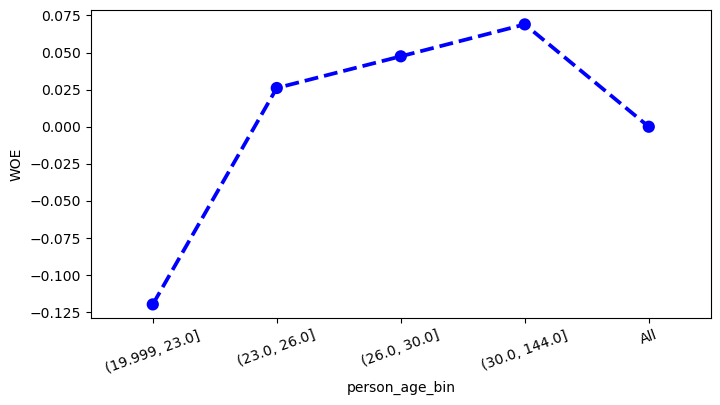

In [75]:
# Plot the WOE of  person_age
plot_WOE(crosstab_age)

- Younger debtors tend to be generally of a higher risk than older debtors.
- Does this make sense in operational or business?



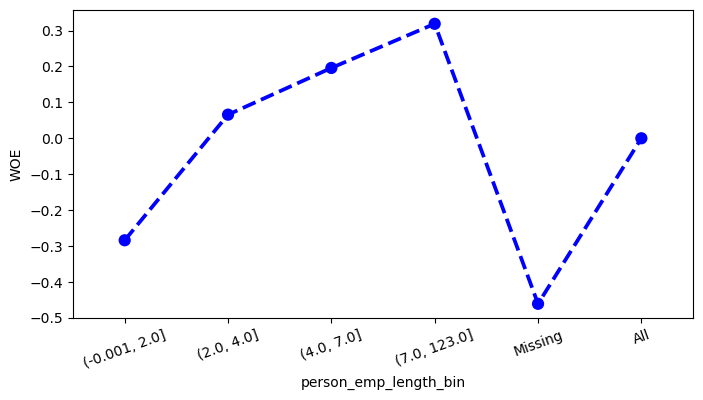

In [76]:
# Plot the WoE of person_emp_length
plot_WOE(crosstab_emp_length)

- Does this make sense in operational or business?
- The WOE of the 'Missing' group is similar to that of an employment length of less than 2 years.

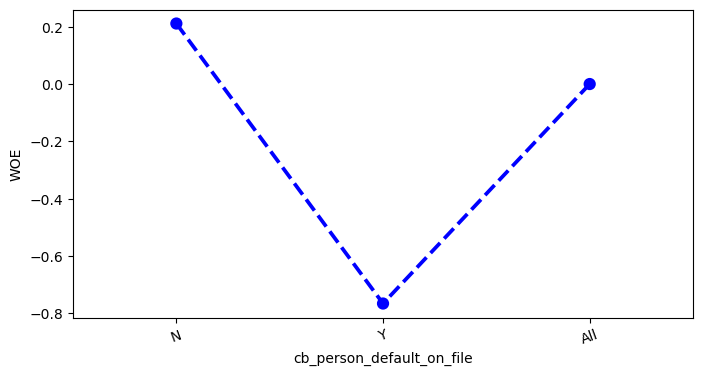

In [77]:
# Plot the WoE of cb_person_default_on_file
plot_WOE(crosstab_default_history)

- The higher odds of default seem from those who have been in default before.
- Does this make sense in operational or business?



### **4. Test of Independence**

- For now, assume that the WOE for each attribute in all characteristics supports the logical trend and operational/business sense.
- Then, we can check the strength of each characteristic as a predictor of credit performance by its Information Value (IV).

In [78]:
# Display the IV Table
IV_table

,Characteristic,Information Value
0,person_age,0.005761
1,person_emp_length,0.064186
2,cb_person_default_on_file,0.159914


The rule of thumb regarding IV:
- Less than 0.02 : generally unpredictive
- 0.02 to 0.1 : weak
- 0.1 to 0.3 : medium
- 0.3+ : strong

In [79]:
# Define the predictive power of each characteristic
strength = []

for iv in IV_table['Information Value']:
  if iv < 0.02:
    strength.append('Unpredictive')
  elif iv >= 0.02 and iv < 0.1:
    strength.append('Weak')
  elif iv >= 0.1 and iv < 0.3:
    strength.append('Medium')
  else:
    strength.append('Strong')

IV_table = IV_table.assign(Strength = strength)
IV_table

,Characteristic,Information Value,Strength
0,person_age,0.005761,Unpredictive
1,person_emp_length,0.064186,Weak
2,cb_person_default_on_file,0.159914,Medium


The predictive power of characteristics varies from very weak to medium.

Next, we check the dependency between each characteristic and the response `loan_status` before modeling.

In [80]:
# Independence test for person_age_bin
independence_test(data = data_train_binned,
                  predictor_label = 'person_age_bin',
                  alpha = 0.05)

Default and person_age_bin is not independent with P-val=4.411132910264968e-05.


In [81]:
# Independence test for person_emp_length_bin
independence_test(data = data_train_binned,
                  predictor_label = 'person_emp_length_bin',
                  alpha = 0.05)

Default and person_emp_length_bin is not independent with P-val=1.2335438683441032e-53.


In [82]:
# Independence test for cb_person_default_on_file
independence_test(data = data_train_binned,
                  predictor_label = 'cb_person_default_on_file',
                  alpha = 0.05)

Default and cb_person_default_on_file is not independent with P-val=1.166741294176887e-156.


All characteristics are not independent of the response variable.


## **6. Design Scorecards**

### **1. Pre-processing Training Set**

- To design the scorecards, we will use a logistic regression model.
- We will perform the logistic regression not against the original input, but rather against the WOE of each grouping created in the previous step.

Therefore, we will transform the training set into the WOE value of each attribute.

#### **Predictor 1: person_age_bin**
---

In [83]:
# Display WOE
crosstab_age['WOE']

person_age_bin
(19.999, 23.0]   -0.119722
(23.0, 26.0]      0.026104
(26.0, 30.0]      0.047449
(30.0, 144.0]     0.068969
All               0.000000
Name: WOE, dtype: float64

In [84]:
# Define the each attribute
age_1 = (data_train['person_age'] >= 19.999) & (data_train['person_age'] < 23)
age_2 = (data_train['person_age'] >= 23) & (data_train['person_age'] < 26)
age_3 = (data_train['person_age'] >= 26) & (data_train['person_age'] < 30)

# Replace the input with WOE
data_train['person_age_WOE'] = np.where(age_1, -0.119722,
                               np.where(age_2, 0.026104,
                               np.where(age_3, 0.047449, 0.068969)))

In [123]:
data_train

,person_age,person_emp_length,cb_person_default_on_file,loan_status,person_age_WOE,person_emp_length_WOE,default_hist_WOE
11491,26,1.0,N,0,0.047449,-0.284110,0.211359
3890,23,3.0,N,0,0.026104,0.065751,0.211359
17344,24,1.0,N,1,0.026104,-0.284110,0.211359
13023,24,1.0,N,0,0.026104,-0.284110,0.211359
29565,42,4.0,N,1,0.068969,0.195896,0.211359
...,...,...,...,...,...,...,...
22095,32,3.0,N,0,0.068969,0.065751,0.211359
18736,30,0.0,N,0,0.068969,-0.284110,0.211359
1663,22,7.0,N,0,-0.119722,0.318867,0.211359
18257,29,4.0,Y,0,0.047449,0.195896,-0.766741


#### **Predictor 2: person_emp_length**
---

In [85]:
# Display WOE
crosstab_emp_length['WOE']

person_emp_length_bin
(-0.001, 2.0]   -0.284110
(2.0, 4.0]       0.065751
(4.0, 7.0]       0.195896
(7.0, 123.0]     0.318867
Missing         -0.461058
All              0.000000
Name: WOE, dtype: float64

In [86]:
# Define the each attribute
emp_length_1 = (data_train['person_emp_length'] >= 0) & (data_train['person_emp_length'] < 2)
emp_length_2 = (data_train['person_emp_length'] >= 2) & (data_train['person_emp_length'] < 4)
emp_length_3 = (data_train['person_emp_length'] >= 4) & (data_train['person_emp_length'] < 7)
emp_length_4 = (data_train['person_emp_length'] >= 7) & (data_train['person_emp_length'] <= 123)

# Replace the input with WOE
data_train['person_emp_length_WOE'] = np.where(emp_length_1, -0.284110,
                                      np.where(emp_length_2, 0.065751,
                                      np.where(emp_length_3, 0.195896,
                                      np.where(emp_length_4, 0.318867, -0.461058))))

#### **Predictor 3: cb_person_default_on_file**
---

In [87]:
# Display WOE
crosstab_default_history['WOE']

cb_person_default_on_file
N      0.211359
Y     -0.766741
All    0.000000
Name: WOE, dtype: float64

In [88]:
# Create label WOE for each attribute
label_default_history = {'N' : 0.211359,
                         'Y' : -0.766741}

# Transform each attribute into WOE
data_train['default_hist_WOE'] = data_train['cb_person_default_on_file'].map(label_default_history)

Check the transformation result.


In [89]:
# Display the training set
data_train

,person_age,person_emp_length,cb_person_default_on_file,loan_status,person_age_WOE,person_emp_length_WOE,default_hist_WOE
11491,26,1.0,N,0,0.047449,-0.284110,0.211359
3890,23,3.0,N,0,0.026104,0.065751,0.211359
17344,24,1.0,N,1,0.026104,-0.284110,0.211359
13023,24,1.0,N,0,0.026104,-0.284110,0.211359
29565,42,4.0,N,1,0.068969,0.195896,0.211359
...,...,...,...,...,...,...,...
22095,32,3.0,N,0,0.068969,0.065751,0.211359
18736,30,0.0,N,0,0.068969,-0.284110,0.211359
1663,22,7.0,N,0,-0.119722,0.318867,0.211359
18257,29,4.0,Y,0,0.047449,0.195896,-0.766741


### **2. Logistic Regression Modeling**
---

In [90]:
# Define X_train and y_train
X_train = data_train[['person_age_WOE',
                      'person_emp_length_WOE',
                      'default_hist_WOE']]

y_train = data_train[response_variable]

In [91]:
# Check X_train
X_train

,person_age_WOE,person_emp_length_WOE,default_hist_WOE
11491,0.047449,-0.284110,0.211359
3890,0.026104,0.065751,0.211359
17344,0.026104,-0.284110,0.211359
13023,0.026104,-0.284110,0.211359
29565,0.068969,0.195896,0.211359
...,...,...,...
22095,0.068969,0.065751,0.211359
18736,0.068969,-0.284110,0.211359
1663,-0.119722,0.318867,0.211359
18257,0.047449,0.195896,-0.766741


In [92]:
# Check y_train
y_train

11491    0
3890     0
17344    1
13023    0
29565    1
        ..
22095    0
18736    0
1663     0
18257    0
10456    1
Name: loan_status, Length: 22806, dtype: int64

We are ready for modeling.

But we need to find the best possible model using all available options.

Thus, we will perform the best subset selection procedure with k-Fold cross-validation.



In [93]:
# Import library
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

#### **Perform Best Subset Selection**
---
Fit a separate model for each possible combination of the $p$ predictors.

1. Define a function `get_scores(predictor_set)` to fit a model of `predictor_set` on train set and calculate its AIC from test set.
  - We use 5-fold cross validation to assess fitted model from train set and calculate AIC score from test set.

In [94]:
def get_scores(predictor_set):
    """
    Function to fit a model on train set and calculate its AIC from test set

    Parameters
    ----------
    predictor_set : tuple object
      The predictor set that will be included in model

    Returns
    -------
    predictor_set : tuple object
      The predictor set from parameters

    AIC : float
      The AIC score from test set
    """
    # Define the estimator
    model = LogisticRegression(penalty = None,
                               class_weight = 'balanced')

    # Perform 5-fold CV to get CV scores (average log likelihood)
    scores = cross_validate(estimator = model,
                            X = X_train[list(predictor_set)],
                            y = y_train,
                            scoring = 'neg_log_loss',
                            cv = 5)

    # Calculate log likelihood from test set
    log_likelihood = np.mean(scores['test_score']*len(X))

    # Calculate AIC from test set
    AIC = -2*(log_likelihood - (len(X.columns)+1))
    AIC = round(AIC, 2)

    return {'Predictors':list(predictor_set), 'AIC':AIC}

In [95]:
# Check the function
get_scores(X_train.columns)

{'Predictors': ['person_age_WOE', 'person_emp_length_WOE', 'default_hist_WOE'],
 'AIC': 43363.99}

2. Define function `best_subset(k)` to choose the best model of each `k` predictors included, with `k`=1,...,p and p denote the number of all predictors.
  - We choose the best model by its AIC score.
  - The best model is model with the smallest AIC score.
  - To get the AIC score of each possible model, we use function `get_scores(predictor_set)`.

In [96]:
def best_subset(k):
    """
    Function to choose the best model of each k predictors included

    Parameters
    ----------
    k : int, in range number of all predictors (p)
      The number of predictors included in model

    Returns
    -------
    models : {array-like} of shape (combination(p, k), k)
      The list of all possible models and its AIC score

    best_models : {array-like} of shape (2, ) contains predictor_set and AIC
      The best model with the smallest AIC in list of possible models

    """
    # Create a list of result from function get_scores(predictor_set)
    results = []

    # Fit model and calculate AIC from each combination of predictors
    for combination in itertools.combinations(X_train.columns, k):
        results.append(get_scores(combination))

    # Tabulate list of results in dataframe
    models = pd.DataFrame(results)

    # Choose the best model with the smallest AIC
    best_model = models.loc[models['AIC'].argmin()]

    # Return the list of possible models and the best model
    return best_model

Now, perform the best subset model selection procedure.


In [97]:
# Create table for best model from each combination of predictors
best_subset_models = pd.DataFrame(columns = ['Predictors', 'AIC'])

# Get the best model k for k=1,...,p
for k in range(1, X_train.shape[1]+1):
    best_subset_models.loc[k] = best_subset(k)

In [98]:
# Print the best models
best_subset_models

,Predictors,AIC
1,[default_hist_WOE],43835.69
2,"[person_emp_length_WOE, default_hist_WOE]",43416.9
3,"[person_age_WOE, person_emp_length_WOE, defaul...",43363.99


- The smallest AIC score comes from the model with all characteristics as predictors.
- To get the best model, refit the model with all characteristics included as predictors.

In [99]:
# Define the model
model = LogisticRegression(penalty =None,
                           class_weight = 'balanced')

# Model fitting
model.fit(X = X_train,
          y = y_train)

LogisticRegression(class_weight='balanced', penalty=None)

In [100]:
# Extract the parameter estimate: intercept
b0 = model.intercept_
b0

array([0.08736195])

In [101]:
# Extract the parameter estimate: slope
bj = model.coef_
bj

array([[-1.35562104, -0.94414054, -1.00195757]])

In [102]:
np.exp(-1.00195757)

0.3671599958258486

### **3. Scaling**
---

Assign score to each attribute by specifying:
- Odds of 50:1 at 200 points score, and
- 20 PDO (points to double the odds).

Thus, we can calculate the offset and factor:
- $\text{Factor}=\text{PDO}/ \ln(2)$
- $\text{Offset} = \text{Score} − {\text{Factor} ∗ \ln (\text{Odds})}$

Therefore, the score point for each attribute $i$:
$$
-\left (\text{WOE}_i \times \beta_j + \frac{\beta_0}{n}  \right )\times \text{Factor}+\frac{\text{Offset}}{n}
$$

In [103]:
# Define Factor and Offset
factor = 20/np.log(2)
offset = 200-(factor*np.log(50))

factor, offset

(28.85390081777927, 87.1228762045055)

In [104]:
# Define n = number of characteristics
n = bj.shape[1]

# Define b0
b0 = b0[0]

b0, n

(0.08736194856091217, 3)

#### **Predictor 1: person_age_bin**
---

In [105]:
# Display WOE
crosstab_age

loan_status,0,1,All,p_good,p_bad,WOE,contribution
person_age_bin,,,,,,,
"(19.999, 23.0]",4671,1469,6140,0.261960,0.295276,-0.119722,0.003989
"(23.0, 26.0]",5007,1361,6368,0.280803,0.273568,0.026104,0.000189
"(26.0, 30.0]",3856,1026,4882,0.216253,0.206231,0.047449,0.000476
"(30.0, 144.0]",4297,1119,5416,0.240985,0.224925,0.068969,0.001108
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [106]:
# Define beta_j for characteristic person_age_bin
b_age = bj[0][0]

b_age

-1.3556210407910065

In [107]:
# Calculate the score point for each attribute
crosstab_age['points'] = -((crosstab_age['WOE']*b_age) + (b0/n)) \
                         * factor + (offset/n)

crosstab_age

loan_status,0,1,All,p_good,p_bad,WOE,contribution,points
person_age_bin,,,,,,,,
"(19.999, 23.0]",4671,1469,6140,0.261960,0.295276,-0.119722,0.003989,23.517799
"(23.0, 26.0]",5007,1361,6368,0.280803,0.273568,0.026104,0.000189,29.221774
"(26.0, 30.0]",3856,1026,4882,0.216253,0.206231,0.047449,0.000476,30.056699
"(30.0, 144.0]",4297,1119,5416,0.240985,0.224925,0.068969,0.001108,30.898415
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000,28.200714


#### Predictor 2: person_emp_length

---

In [108]:
# Display the crosstab
crosstab_emp_length

loan_status,0,1,All,p_good,p_bad,WOE,contribution
person_emp_length_bin,,,,,,,
"(-0.001, 2.0]",5533,2051,7584,0.310302,0.412261,-0.284110,0.028968
"(2.0, 4.0]",3510,917,4427,0.196848,0.184322,0.065751,0.000824
"(4.0, 7.0]",4460,1023,5483,0.250126,0.205628,0.195896,0.008717
"(7.0, 123.0]",3885,788,4673,0.217879,0.158392,0.318867,0.018968
Missing,443,196,639,0.024844,0.039397,-0.461058,0.006710
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [109]:
# Define beta_j for characteristic person_emp_length
b_emp_length = bj[0][1]

b_emp_length

-0.9441405428964565

In [110]:
# Calculate the score point for each attribute
crosstab_emp_length['points'] = -((crosstab_emp_length['WOE']*b_emp_length) + (b0/n)) \
                                * factor + (offset/n)

crosstab_emp_length

loan_status,0,1,All,p_good,p_bad,WOE,contribution,points
person_emp_length_bin,,,,,,,,
"(-0.001, 2.0]",5533,2051,7584,0.310302,0.412261,-0.284110,0.028968,20.460938
"(2.0, 4.0]",3510,917,4427,0.196848,0.184322,0.065751,0.000824,29.991904
"(4.0, 7.0]",4460,1023,5483,0.250126,0.205628,0.195896,0.008717,33.537344
"(7.0, 123.0]",3885,788,4673,0.217879,0.158392,0.318867,0.018968,36.887334
Missing,443,196,639,0.024844,0.039397,-0.461058,0.006710,15.640508
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000,28.200714


#### **Predictor 3: cb_person_default_on_file**
---

In [111]:
# Display WOE
crosstab_default_history

loan_status,0,1,All,p_good,p_bad,WOE,contribution
cb_person_default_on_file,,,,,,,
N,15302,3456,18758,0.858168,0.694673,0.211359,0.034556
Y,2529,1519,4048,0.141832,0.305327,-0.766741,0.125358
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [112]:
# Define beta_j for characteristic default history
b_default_hist = bj[0][2]

b_default_hist

-1.0019575748534904

In [113]:
# Calculate the score point for each attribute
crosstab_default_history['points'] = -((crosstab_default_history['WOE']*b_default_hist) + (b0/n)) \
                                     * factor + (offset/n)

crosstab_default_history

loan_status,0,1,All,p_good,p_bad,WOE,contribution,points
cb_person_default_on_file,,,,,,,,
N,15302,3456,18758,0.858168,0.694673,0.211359,0.034556,34.311171
Y,2529,1519,4048,0.141832,0.305327,-0.766741,0.125358,6.033926
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000,28.200714
